In [4]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# !pip install emoji

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading dataset

In [5]:
train_data = pd.read_csv('./datasets/training-v1/offenseval-training-v1.tsv' , sep='\t')

## Exploratory Data Analysis

In [6]:
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
id           13240 non-null int64
tweet        13240 non-null object
subtask_a    13240 non-null object
subtask_b    4400 non-null object
subtask_c    3876 non-null object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


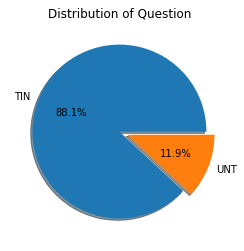

In [8]:
ax=train_data['subtask_b'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

Targeted:  524
Un Targeted:  3876


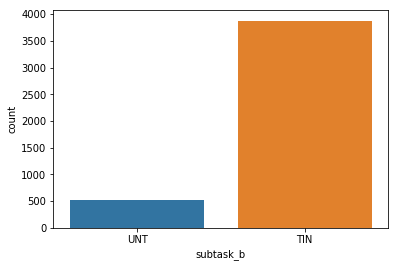

In [9]:
plot_sb = sb.countplot(train_data['subtask_b'], label='Total')
unTargeted, targeted = train_data['subtask_b'].value_counts()
print('Targeted: ', targeted )
print('Un Targeted: ',unTargeted)

## Preprocessing Dataset

In [10]:
def handle_emoji(text):
    # Dictionnary of "important" emojis : 
    emoji_dict =  {'♥️': ' love ',
                   '❤️' : ' love ',
                   '❤' : ' love ',
                   '😘' : ' kisses ',
                  '😭' : ' cry ',
                  '💪' : ' strong ',
                  '🌍' : ' earth ',
                  '💰' : ' money ',
                  '👍' : ' ok ',
                   '👌' : ' ok ',
                  '😡' : ' angry ',
                  '🍆' : ' dick ',
                  '🤣' : ' haha ',
                  '😂' : ' haha ',
                  '🖕' : ' fuck you '}

    for cha in emoji_dict:
        text = re.compile(str(cha)).sub(str(emoji_dict[cha]),text)
    # Remove ALL emojis
    text = emoji.get_emoji_regexp().sub(r' ',text) 
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

    # Add Space between  the Emoji Expressions : 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text


In [11]:
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [12]:
train_data['subtask_b'].replace({'UNT':0, 'TIN': 1}, inplace= True)

In [13]:
train_data["preprocessed_tweet"] = train_data["tweet"].apply(clean_tweet)

In [14]:
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,0.0,NaN,<user> she should ask a few native americans w...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1.0,IND,<user> go home you re drunk ! <user> maga trum...
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,0.0,NaN,<user> someone should ' ve taken this piece of...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,<user> obama wanted liberals and amp illegals ...


In [15]:
train_data = train_data.dropna(subset=['subtask_b'])

In [16]:
train_data.shape

(4400, 6)

## Word Cloud

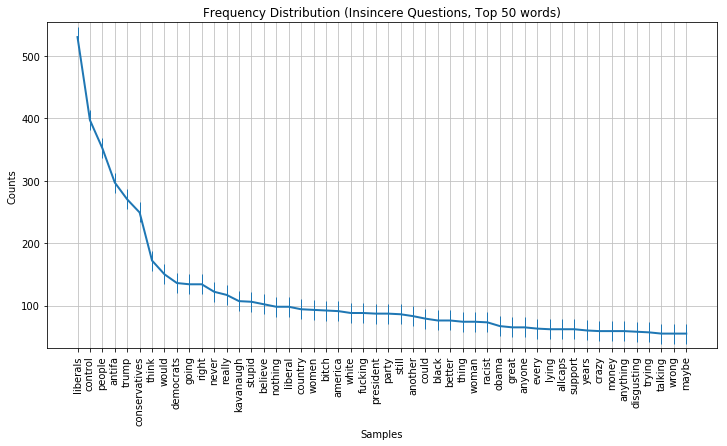

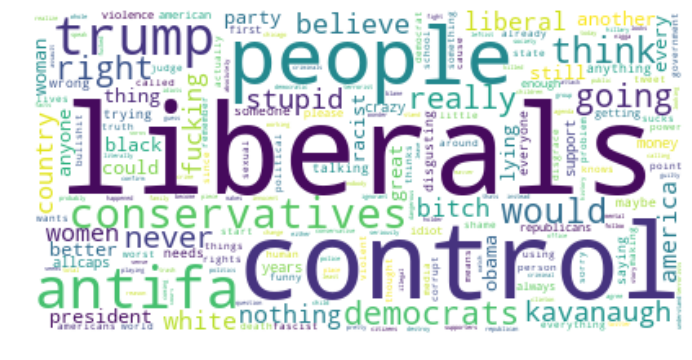

In [17]:
offensive = train_data.loc[train_data['subtask_b'] == 1].values
len(offensive)
offensive[0][1]

stop_words = set(stopwords.words('english'))
word_tokens = [word_tokenize(question[5]) for question in offensive]

#freq_dist = FreqDist([word for question in insincere_questions for word in question[1].split()])
all_words = [word for question in word_tokens for word in question]
len(all_words)
without_stopwords = [w for w in all_words if not w in stop_words]
words_len = [w for w in without_stopwords if not len(w)<5]
freq_dist = FreqDist([word for word in words_len])

plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Insincere Questions, Top 50 words)')
freq_dist.plot(50, marker='|', markersize=20)
plt.show()

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Extraction

In [18]:
X = train_data["preprocessed_tweet"].values
y = train_data["subtask_b"].values

In [19]:
y

array([0., 1., 0., ..., 1., 1., 0.])

In [20]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
#train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)

In [21]:
print("Train shape : ",train_X.shape)
#print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3300,)
Test shape :  (1100,)


In [22]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

# unique, counts = np.unique(val_y, return_counts=True)
# print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 3.930e+02]
 [1.000e+00 2.907e+03]]
[[  0. 131.]
 [  1. 969.]]


In [23]:
testdf = pd.DataFrame()
testdf['tweet'] = test_X

testdf['subtask_b'] = test_y
testdf.shape

(1100, 2)

### Using TFIDF

In [24]:
def tfidf_vectorizer(X, train_X, test_X):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X)

    train_text_features_tf = tfidf_vectorizer.transform(train_X)
    test_text_features_tf = tfidf_vectorizer.transform(test_X)
    
    return train_text_features_tf, test_text_features_tf

### Using Count Vectorizer

In [25]:
def count_vectorizer(X, train_X, test_X):
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(X)

    train_text_features_cv = count_vectorizer.transform(train_X)
    test_text_features_cv = count_vectorizer.transform(test_X)
    
    return train_text_features_cv, test_text_features_cv

## Undersampling

In [26]:
def undersampleData(train_text_features_tf, train_y):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
    return X_resampled, y_resampled

## Oversampling

In [27]:
def oversampleData(train_text_features_tf, train_y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    x_oversampled, y_oversampled = smote.fit_sample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

## Function for Confusion Matrix

In [28]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

## Model

In [90]:
def model(model, X, train_X, train_y, test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False):
    
    if tfidf:
        print('Feature Extraction using TFIFD')
        train_text_features, test_text_features = tfidf_vectorizer(X, train_X, test_X)
    
    if cv:
        print('Feature Extraction using CV')
        train_text_features, test_text_features = count_vectorizer(X, train_X, test_X)

    if undersampled:
        print('Undersampling the dataset')
        train_text_features, train_y = undersampleData(train_text_features, train_y)

    if oversample:
        print('Oversampling the dataset')
        train_text_features, train_y = oversampleData(train_text_features, train_y)
        
    model.fit(train_text_features, train_y)

    # predict the labels on validation dataset
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions, test_y)*100)

    print('F1Score', f1_score(predictions, test_y, average="macro"))
    print('Precision', precision_score(predictions, test_y, average="macro"))
    print('Recall', recall_score(predictions, test_y, average="macro"))

    getConfusionMatrix(test_y, predictions)

## Naive Bayes (Unsampling, TFIDF)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  75.45454545454545
F1Score 0.5687627411008311
Precision 0.6065196669266341
Recall 0.5641769226022944
Sensitivity: 80.08%
Specificity: 41.22%


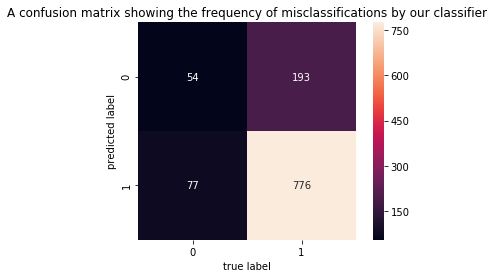

In [91]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

## Naive Bayes (Unsampling, CV)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  74.36363636363636
F1Score 0.5605609859753506
Precision 0.6003277164622378
Recall 0.5584682695265335
Sensitivity: 78.84%
Specificity: 41.22%


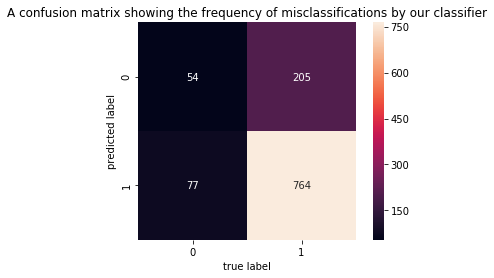

In [92]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

## Naive Bayes

Feature Extraction using CV
Accuracy Score ->  86.81818181818181
F1Score 0.4907261064334544
Precision 0.5059792498759247
Recall 0.5320037105751392
Sensitivity: 98.14%
Specificity: 3.05%


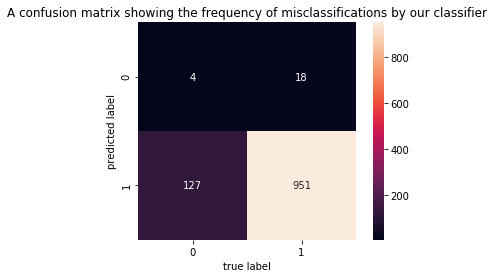

In [93]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Accuracy Score ->  88.0909090909091
F1Score 0.4683421942967617
Precision 0.5
Recall 0.44045454545454543
Sensitivity: 100.00%
Specificity: 0.00%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


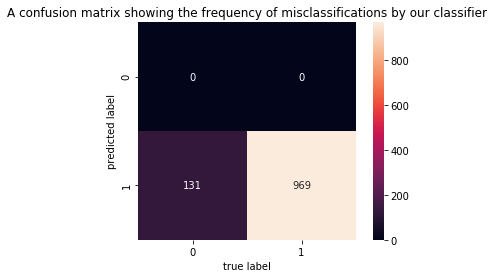

In [94]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)

### Naive Bayes (Oversampling, CV)

Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  76.54545454545455
F1Score 0.5676838333861415
Precision 0.5962076272855467
Recall 0.562031746031746
Sensitivity: 81.84%
Specificity: 37.40%


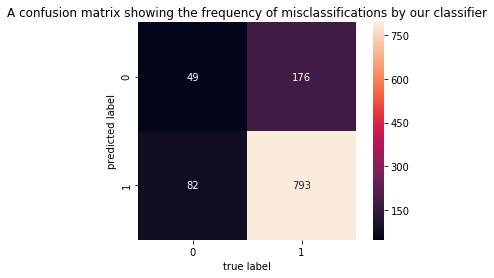

In [95]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)

### Naive Bayes (Oversampling, TFIDF)

Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  76.54545454545455
F1Score 0.5715579710144927
Precision 0.60280922332774
Recall 0.5654294867616904
Sensitivity: 81.63%
Specificity: 38.93%


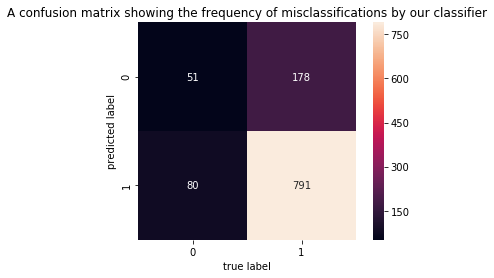

In [96]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)

## SVM (Undersampling, TFIDF)


Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  64.54545454545455
F1Score 0.5190065298507462
Precision 0.6073153246835095
Recall 0.5483968380850874
Sensitivity: 65.74%
Specificity: 55.73%


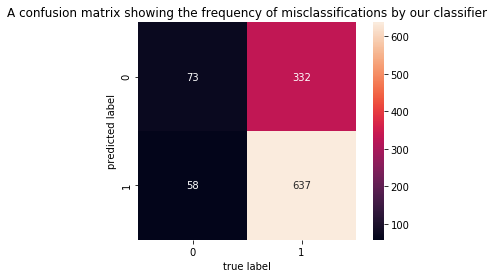

In [97]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

## SVM (Undersampling, CV)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  56.63636363636364
F1Score 0.47873979608563094
Precision 0.605334058090894
Recall 0.5443517891971501
Sensitivity: 55.42%
Specificity: 65.65%


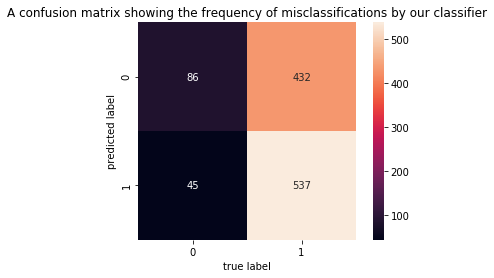

In [98]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

## SVM

Feature Extraction using CV
Accuracy Score ->  82.36363636363636
F1Score 0.5178752168883748
Precision 0.5170042303783707
Recall 0.5230483390460327
Sensitivity: 91.95%
Specificity: 11.45%


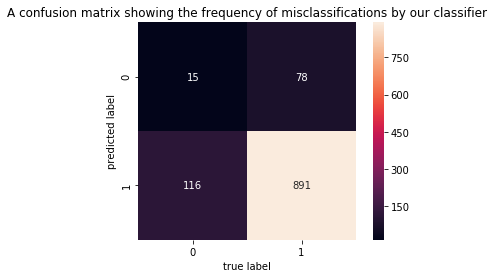

In [99]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Accuracy Score ->  88.18181818181819
F1Score 0.49056657546739624
Precision 0.5104183899353233
Recall 0.741552511415525
Sensitivity: 99.79%
Specificity: 2.29%


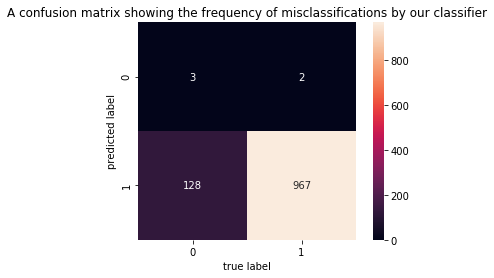

In [100]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  83.0909090909091
F1Score 0.5803076923076923
Precision 0.5772457637132796
Recall 0.5839950659162748
Sensitivity: 91.02%
Specificity: 24.43%


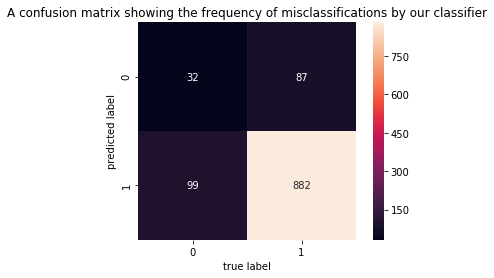

In [101]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)

Feature Extraction using CV
Oversampling the dataset
Accuracy Score ->  74.81818181818181
F1Score 0.5326622606753775
Precision 0.5500949274848549
Recall 0.5326243099591619
Sensitivity: 81.01%
Specificity: 29.01%


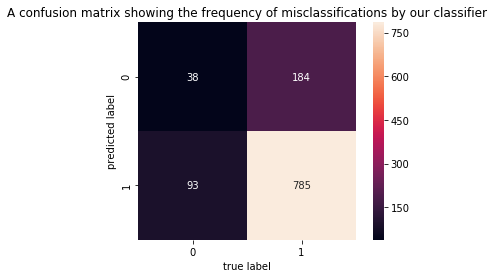

In [102]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = True)

### Random Forest

Feature Extraction using CV
Oversampling the dataset
Accuracy Score ->  65.27272727272727
F1Score 0.5138014662322274
Precision 0.5850369074909996
Recall 0.5394047579935679
Sensitivity: 67.39%
Specificity: 49.62%


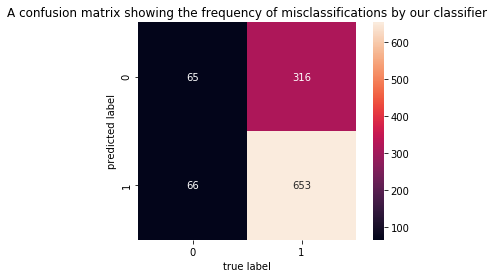

In [103]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = True)


Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  50.0
F1Score 0.43543209507883424
Precision 0.5775687534957736
Recall 0.5327898605019797
Sensitivity: 47.57%
Specificity: 67.94%


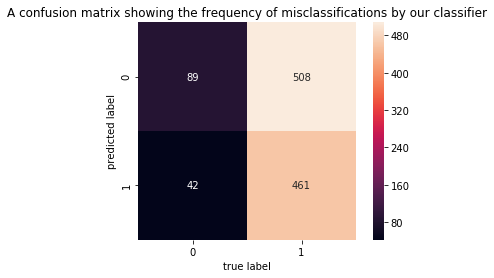

In [104]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)


Feature Extraction using CV
Accuracy Score ->  88.0909090909091
F1Score 0.4683421942967617
Precision 0.5
Recall 0.44045454545454543
Sensitivity: 100.00%
Specificity: 0.00%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


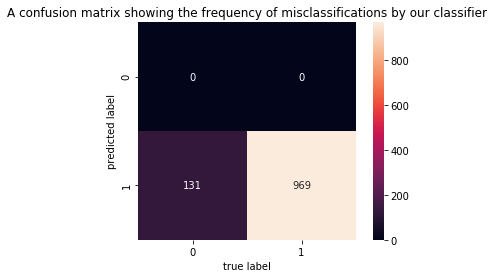

In [105]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)


Feature Extraction using TFIFD
Accuracy Score ->  88.0909090909091
F1Score 0.4683421942967617
Precision 0.5
Recall 0.44045454545454543
Sensitivity: 100.00%
Specificity: 0.00%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


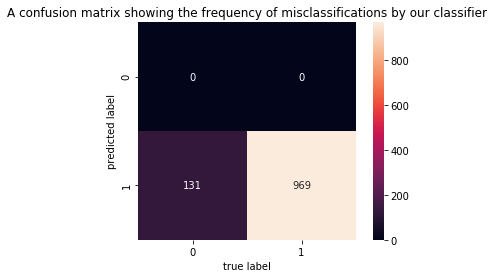

In [106]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)


Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  56.99999999999999
F1Score 0.4693843001797954
Precision 0.5677884653258651
Recall 0.5287888926062229
Sensitivity: 57.07%
Specificity: 56.49%


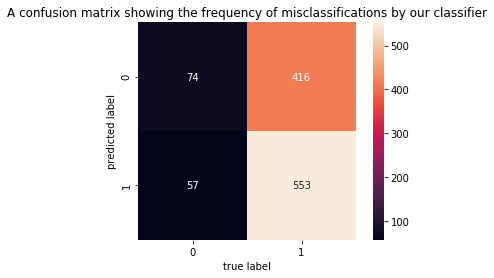

In [107]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)


Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  85.81818181818181
F1Score 0.6212756565879497
Precision 0.609229629979754
Recall 0.6399156399156399
Sensitivity: 93.60%
Specificity: 28.24%


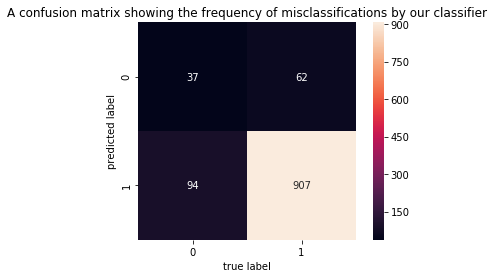

In [108]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)


## Logistic Regression

Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  82.18181818181817
F1Score 0.5939919852963331
Precision 0.5984921891617233
Recall 0.590287055425167
Sensitivity: 89.16%
Specificity: 30.53%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


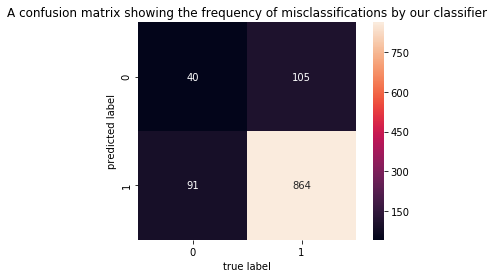

In [109]:
#Random Forest Classifier 
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)


Feature Extraction using CV
Oversampling the dataset
Accuracy Score ->  76.0
F1Score 0.5576299690462843
Precision 0.5832092579900582
Recall 0.5536507936507936
Sensitivity: 81.53%
Specificity: 35.11%


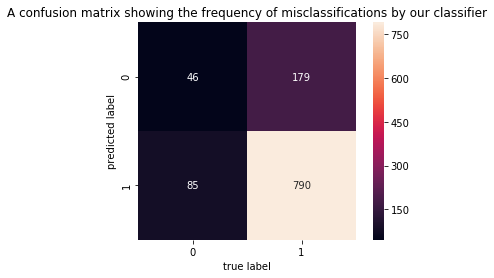

In [110]:
#Random Forest Classifier 
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = True)


Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  66.54545454545455
F1Score 0.5414673046251994
Precision 0.6417728200159132
Recall 0.5644825522858136
Sensitivity: 67.29%
Specificity: 61.07%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


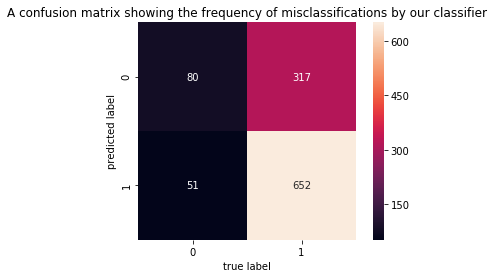

In [111]:
#Random Forest Classifier 
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)


Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  58.72727272727273
F1Score 0.4921824157230248
Precision 0.6139011651265569
Recall 0.5483156280179515
Sensitivity: 57.89%
Specificity: 64.89%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


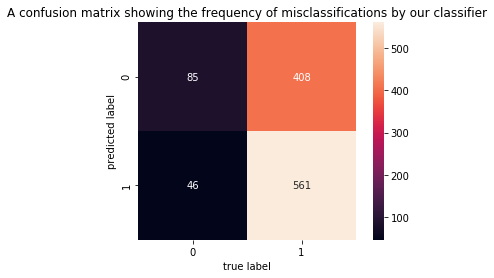

In [112]:
#Random Forest Classifier 
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)


Feature Extraction using CV
Accuracy Score ->  87.18181818181819
F1Score 0.5328749423999566
Precision 0.531148819511734
Recall 0.6156952247191011
Sensitivity: 97.83%
Specificity: 8.40%


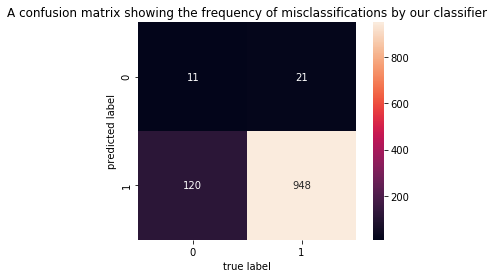

In [113]:
#Random Forest Classifier 
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)


Feature Extraction using TFIFD
Accuracy Score ->  88.36363636363636
F1Score 0.4914103249483464
Precision 0.5114503816793893
Recall 0.9416590701914311
Sensitivity: 100.00%
Specificity: 2.29%


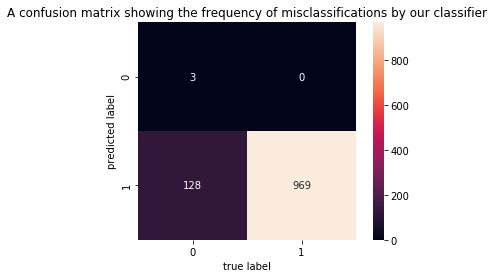

In [114]:
#Random Forest Classifier 
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)
